3. Group Proposed Project (10 marks)
3.1 At this point, you understand the data quite well. Carry out the analysis you proposed
in your group project proposal. You should use the dataset given but you may also use
additional datasets to supplement your analysis, look at unaggregated data, etc. Please
be sure to justify why the analysis is useful and interesting in the context of a data science
project. Note that you are not limited to the initial proposal and are free to expand on
it.
3.2 Based on the insights derived from the analysis, suggest a practical action that can be
taken (i.e., an action that can be taken to benefit society. Do not suggest actions such as
hyperparameter tuning here).

In [2]:
WINDOW_SIZE = 5
CLUSTER_COUNT = 50

In [3]:
import requests
import csv
import json
import pandas as pd
from datetime import datetime
from time import sleep
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import numpy as np
from sklearn import datasets, metrics
from pathlib import Path
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm
import math


In [4]:
def fxn():
    warnings.warn("deprecated", DeprecationWarning)


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

# Convert to datetime iso


def toIso(dt):
    return datetime.fromisoformat(dt)


def carparkApiCall(year, month, day, hour, minute, second, error_count):
    def find_local_file(year, month, day, hour, fDir):
        myDir = Path('./data/')
        filePaths = [file for file in myDir.iterdir() if file.name.startswith(
            f'{year}{month}{day}T{hour.zfill(2)}')]
        is_file_local = False
        for file in filePaths:
            if os.path.isfile(file):  # check if file exist
                open(file, 'r')
                fDir = file
                is_file_local = True
                break
        return fDir, is_file_local

    def print_api_error(year, month, day, hour, minute, second, error_count, data):
        print(data)
        print(year, '/', month, '/', day, 'T', hour, minute, second)
        print("error count:", error_count)

    def write_to_file(fDir, data):
        timestamp = data["items"][0]["timestamp"]
        data = data["items"][0]["carpark_data"]
        # create file if response is valid
        os.makedirs(os.path.dirname('./data/'), exist_ok=True)
        with open(fDir, 'w') as fp:
            json.dump(data, fp)
        return data

    def read_from_file(fDir):
        # read from file
        df = pd.read_json(fDir)
        for heading in ("total_lots", "lot_type", "lots_available"):
            df[heading] = df["carpark_info"].apply(lambda x: x[0][heading])

        # Transform data
        df = df.drop(["carpark_info"], axis=1)
        df['update_datetime'] = df['update_datetime'].apply(toIso)
        df["lots_available"] = df["lots_available"].astype(int)
        df["total_lots"] = df["total_lots"].astype(int)
        return df

    def api_call_to_json(year, month, day, hour, minute, second):
        site = f'https://api.data.gov.sg/v1/transport/carpark-availability?date_time={year}-{month.zfill(2)}-{day.zfill(2)}T{hour.zfill(2)}%3A{minute.zfill(2)}%3A{second.zfill(2)}'
        response_API = requests.get(site)
        data = response_API.text
        data = json.loads(data)
        return response_API, data

    fail_count = 0
    max_time_diff, time_diff = 25, 0
    fDir = f'./data/{year}{month}{day}T{hour.zfill(2)}{minute.zfill(2)}{second.zfill(2)}.json'
    fDir, is_file_local = find_local_file(year, month, day, hour, fDir)

    while not is_file_local and time_diff <= max_time_diff and fail_count < error_count:  # If file doesn't exist, api call
        new_min = str(int(minute) + time_diff)
        response_API, data = api_call_to_json(
            year, month, day, hour, new_min, new_min)

        # check if response is valid
        if response_API.ok and "items" in data and len(data["items"]) > 0 and "timestamp" in data["items"][0] and "carpark_data" in data["items"][0]:
            data = write_to_file(fDir, data)
            break
        elif time_diff < max_time_diff:
            time_diff += 1
            print_api_error(year, month, day, hour, new_min,
                            new_min, fail_count, time_diff)
        else:
            fail_count += 1
            time_diff = 0
            print_api_error(year, month, day, hour, new_min,
                            new_min, fail_count, time_diff)

    df = read_from_file(fDir)
    return df


# Calculate average availability in percentage
def avrAvail(df):
    df["availability_percentage"] = df["lots_available"]/df["total_lots"]
    return df["availability_percentage"]


def addDayHour(df, day, hour):
    df["day"] = day
    df["hour"] = hour
    return df


def removeCountTotalAvail(df):
    df = df.drop(columns = ['lots_available', 'total_lots', 'availability_percentage'])
    return df

def removeXY(df):
    df = df.drop(columns = ['x_coord', 'y_coord'])
    return df


In [5]:

carpark_rates_dir = f'./data/hdb-carpark-information.csv'
coord_df = pd.read_csv(carpark_rates_dir) 
coord_df[["car_park_no","x_coord","y_coord"]]

,car_park_no,x_coord,y_coord
0,ACB,30314.7936,31490.4942
1,ACM,33758.4143,33695.5198
2,AH1,29257.7203,34500.3599
3,AK19,28185.4359,39012.6664
4,AK31,29482.0290,38684.1754
...,...,...,...
2177,Y77M,29850.1522,45576.0125
2178,Y78M,30057.2209,45166.4820
2179,Y8,27772.9219,45686.2734
2180,Y82M,29935.5818,45679.7181


In [6]:
carparks = set()
location = dict()
for index,row in coord_df[["car_park_no","x_coord","y_coord"]].iterrows():
    carparks.add(row["car_park_no"])
    if row["car_park_no"] not in location:
        location[row["car_park_no"]] = [row["x_coord"],row["y_coord"]]
print(len(carparks),len(location))

2182 2182


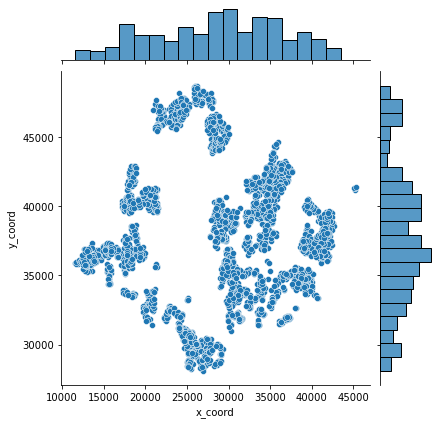

In [7]:
sns.jointplot(data=coord_df,x='x_coord',y='y_coord')

<AxesSubplot:xlabel='x_coord', ylabel='y_coord'>

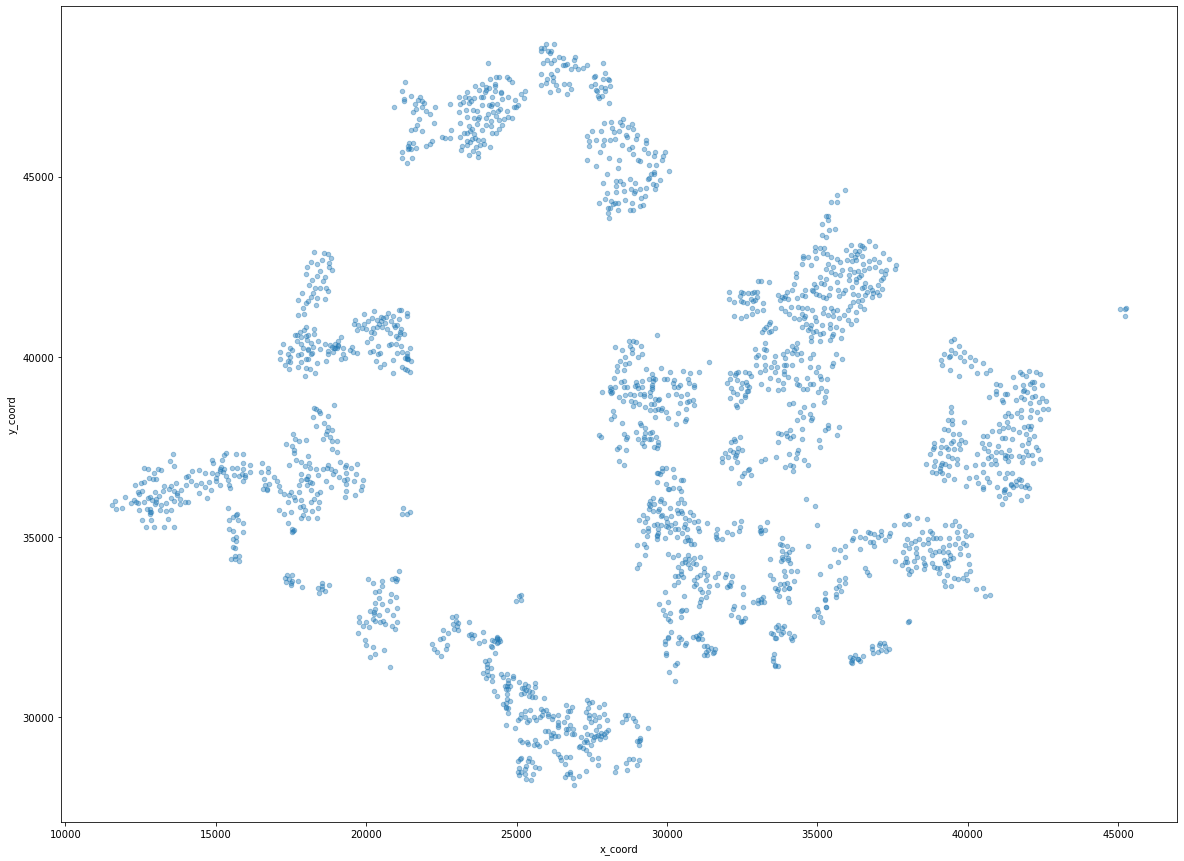

In [8]:
coord_df.plot(x="x_coord",y="y_coord",kind="scatter",alpha=0.4,figsize=(20,15))

Seperating the carparks into cluster by using k-means clustering

In [9]:
scaler = StandardScaler()
coord_df[["x_coord_T","y_coord_T"]] = scaler.fit_transform(coord_df[["x_coord","y_coord"]])

In [10]:
def optimise_k_means(data,max_k):
    means = []
    inertias = []
    
    for k in range(1,max_k):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        
        means.append(k)
        inertias.append(kmeans.inertia_)
        
    fig = plt.subplots(figsize = (10,5))
    plt.plot(means,inertias,'o-')
    plt.xlabel("Number of clusters")
    plt.ylabel("Inertia")
    plt.grid(True)
    plt.show()

In [11]:
# optimise_k_means(coord_df[["x_coord_T","y_coord_T"]],50)

In [12]:
kmeans = KMeans(n_clusters=CLUSTER_COUNT,random_state = 1)
kmeans.fit(coord_df[["x_coord_T","y_coord_T"]])

KMeans(n_clusters=50, random_state=1)

In [13]:
coord_df["kmeans"] = kmeans.labels_
coord_df = coord_df[["car_park_no","x_coord","y_coord","kmeans"]]

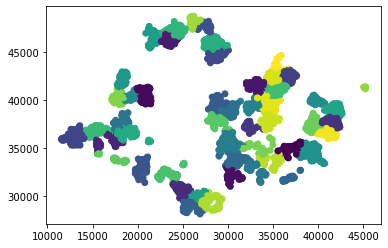

In [14]:
plt.scatter(x=coord_df["x_coord"],y=coord_df["y_coord"],c=coord_df["kmeans"])
plt.show()

In [15]:
def merge_on_col(df1,df2,col1,col2):
    return pd.merge(df1, df2, left_on=col1, right_on=col2, how='right').drop(col1, axis=1)

In [16]:
# start date 15 June 2022 0101

year = 2022
month = 6
day = 15
hour = 1
minute = 1
second = 1
ls=[]
datetime_df = datetime(year=year, month=month, day=day, hour=hour)
dt_interval = timedelta(hours = 1)
total_hrs = 24*7*19 #24 hours, 7 days a week, 19 weeks
clutster_dataframes = [[] for a in range(CLUSTER_COUNT)]
# day of week,time of day
train_x = []
# avalibility percentage
train_y = []
failed = []
for hr in tqdm(range(total_hrs)):
    try:
        datetime_df = datetime_df + dt_interval
        data = carparkApiCall(str(datetime_df.year), str(datetime_df.month), str(datetime_df.day), str(datetime_df.hour), str(datetime_df.minute), str(datetime_df.second), 5)
        new_df = merge_on_col(coord_df,data,"car_park_no","carpark_number")
        new_df1 = new_df.groupby(["kmeans"]).sum()
        new_df1['percentage_avalible'] = new_df1.apply(lambda row: row.lots_available/row.total_lots, axis=1)
        for cluster_no, row in new_df1.iterrows():
            clutster_dataframes[int(cluster_no)].append([datetime_df,row['percentage_avalible']])
    except:
        failed.append(datetime_df)
        continue
failed_dates_df = pd.DataFrame(failed)


  0%|          | 0/3192 [00:00<?, ?it/s]

In [17]:
#should not show anything, if a date is shown means it failed to add
failed_dates_df

""


In [18]:
df = pd.DataFrame(np.array(clutster_dataframes[2]),columns=["datetime","percentage"])
df['dayofweek']= df['datetime'].dt.dayofweek
df['hour']= df['datetime'].dt.hour
df = df.set_index("datetime")
df.head()



,percentage,dayofweek,hour
datetime,,,
2022-06-15 02:00:00,0.516238,2,2
2022-06-15 03:00:00,0.512231,2,3
2022-06-15 04:00:00,0.534585,2,4
2022-06-15 05:00:00,0.529313,2,5
2022-06-15 06:00:00,0.526782,2,6


In [19]:
def window_input_output(input_length, output_length, data):
    df = data.copy()
    
    i = 1
    while i < input_length:
        df[f'forward_{i}'] = df['percentage'].shift(-i)
        i = i + 1
        
    j = 0
    while j < output_length:
        df[f'lag_{j}'] = df['percentage'].shift(-output_length-j)
        j = j + 1
        
    df = df.dropna(axis=0)
    
    return df


In [20]:
seq_df = window_input_output(24*7, 24*7, df)

C:\Users\Ethan Wong\AppData\Local\Temp\ipykernel_32276\700900489.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'forward_{i}'] = df['percentage'].shift(-i)
C:\Users\Ethan Wong\AppData\Local\Temp\ipykernel_32276\700900489.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'forward_{i}'] = df['percentage'].shift(-i)
C:\Users\Ethan Wong\AppData\Local\Temp\ipykernel_32276\700900489.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

In [24]:
from sklearn.tree import DecisionTreeRegressor 
X_cols = [col for col in seq_df.columns if col.startswith('forward_')or col == 'dayofweek' or col == 'hour']

X_cols.insert(0, 'percentage')

y_cols = [col for col in seq_df.columns if col.startswith('lag_')]

split_ratio = 5/6
split_num = int(split_ratio * len(clutster_dataframes[0]))
testdf = seq_df.iloc[split_num:,: ].copy()
trainingdf = seq_df.iloc[:split_num,: ].copy()

X_train = trainingdf[X_cols].values
y_train = trainingdf[y_cols].values

X_test = testdf[X_cols].values
y_test = testdf[y_cols].values



start = 1
depth = start
final_depth = 0
mse_arr = []
mse = 99999999999999999


# while depth<=10: 
#     temp_regressor = DecisionTreeRegressor(max_depth=depth) 
#     temp_regressor.fit(X_train, y_train)
#     predicted = temp_regressor.predict(X_test)
#     temp_mse = mean_squared_error(y_test[1], predicted[1])
#     mse_arr.append(temp_mse)
#     if mse - temp_mse > 0.0001: 
#         mse = temp_mse
#         regressor = temp_regressor
#         final_depth = depth
#     depth += 1

# print(f" mse: {mse} depth: {final_depth}")



regressor = DecisionTreeRegressor(max_depth=9) 
regressor.fit(X_train, y_train)
pred = regressor.predict(X_test)

In [26]:
mse = mean_squared_error(y_test, pred)

print(mse)

0.001027593678008883


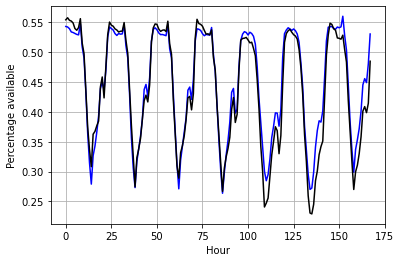

In [27]:
plt.plot([x for x in range(len(pred[1]))], pred[1], color="blue", label = 'predicted') # predicted
# plt.plot(x_grid, predicted, color="blue", linewidth=3)
plt.plot([y for y in range(len(y_test[1]))], np.array(y_test[1]), color="black", label ='actual') #actual
plt.grid(True)
plt.xlabel("Hour")
plt.ylabel("Percentage available")
# plt.legend(loc='upper left')
plt.show()